In [1]:
import torch
import torch.nn as nn
from typing import Optional, Tuple
import numpy as np
import math

from matplotlib import pyplot as plt
%matplotlib inline

torch.Size([2, 1024, 4])


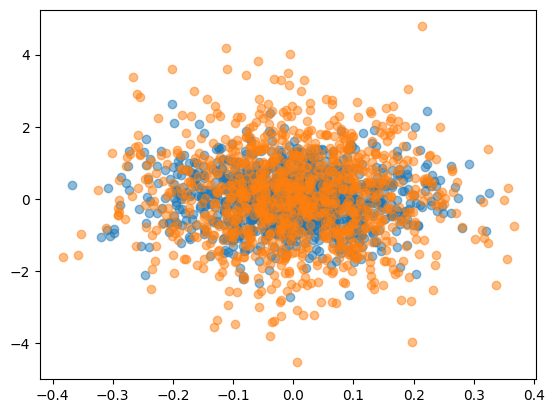

In [3]:
# g is groups, l is length (population), d is head dim and d_ is underlying head dim
# Scatter plots work well for small d/d_, while large values work well for illustrating 2xSVD vs PLS

g = 2  # Don't change this, this demo only works with g=2
l = 1024
d = 4
d_ = 2

test = torch.randn(1,l,d_)
m = torch.randn(g,d_,d)
test = test.matmul(m) + torch.randn(g,l,d)/10
print(test.shape)

def pcavis(x):
    # x: g n d
    m = x.view(-1, x.size(2))  # gn d
    proj = torch.linalg.eigh(m.t().matmul(m))[1][:,:2]
    m = m.matmul(proj)  # gn 2
    m = m.view(x.size(0), x.size(1), 2)
    plt.figure()
    for i in range(g):
        plt.scatter(m[i,:,0], test[i,:,1], alpha=.5)
    plt.show()

pcavis(test)

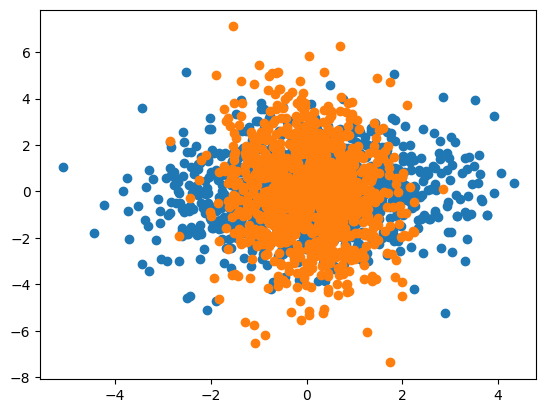

In [4]:
# Perform PLS alignment

xy = test[0].t().matmul(test[1]).div(test.size(1)-1)
yx = test[1].t().matmul(test[0]).div(test.size(1)-1)
vals, vecs = torch.linalg.eigh(xy.matmul(yx))
w0 = vecs[vals.sort()[1]]
vals, vecs = torch.linalg.eigh(yx.matmul(xy))
w1 = vecs[vals.sort()[1]]

plt.figure()
t0 = test[0].matmul(w0)
t1 = test[1].matmul(w1)
plt.scatter(t0[:,-2], t0[:,-1])
plt.scatter(t1[:,-2], t1[:,-1])
plt.show()

In [5]:
# Verify that the y-to-x transformation from PLS is a rotation, by comparing inverse to transpose

r = w0.inverse().matmul(w1)

r.t().sub(r.inverse()).abs().mean().item()

1.0686926543712616e-07

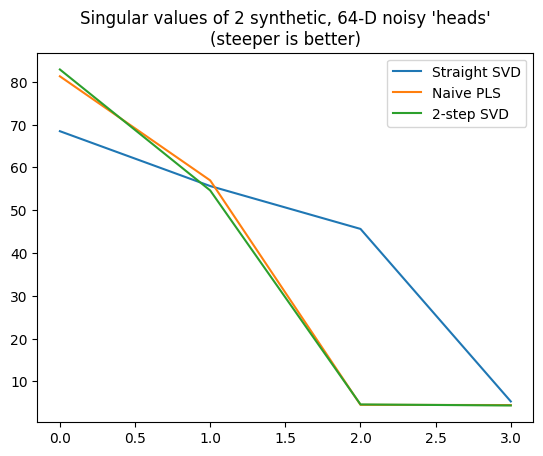

In [6]:
# Perform per-head SVD, and compare to naive compression and PLS compression

plt.figure()

bad = test.view(-1,d)
_,v,_ = torch.linalg.svd(bad)
plt.plot(v, label="Straight SVD")

good = torch.cat([t0,t1], dim=0)
_,v,_ = torch.linalg.svd(good)
plt.plot(v, label="Naive PLS")

# Concatenate the re-aligned heads, and do SVD again (globally)
maybe = torch.cat([
    test[0].matmul(torch.linalg.svd(test[0])[2].t()),
    test[1].matmul(torch.linalg.svd(test[1])[2].t()),
], dim=0)
_,v,_ = torch.linalg.svd(maybe)
plt.plot(v, label="2-step SVD")

plt.title("Singular values of 2 synthetic, 64-D noisy 'heads'\n(steeper is better)")
plt.legend()

plt.show()

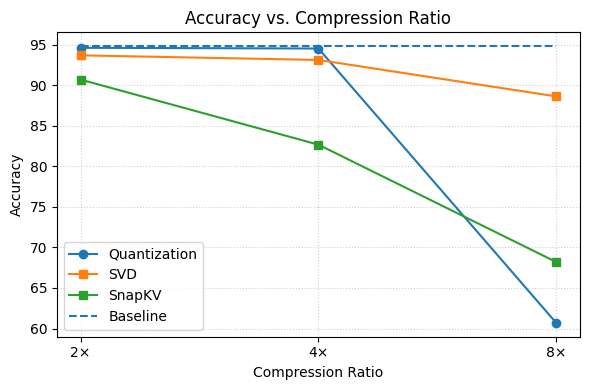

In [4]:
import matplotlib.pyplot as plt
import numpy as np


x_labels = ["2×", "4×", "8×"]           
x = np.arange(len(x_labels))

# ppl_3bit = [6.11, ,]   
# ppl_4bit = [/* r1_4bit */, /* r2_4bit */, /* r3_4bit */] 
Quant = [94.6, 94.51, 60.7]
svd = [93.67,93.1,88.61]
SnapKV = [90.68, 82.66, 68.2]

baseline =94.8                          

# ==== 作图 ====
plt.figure(figsize=(6,4))  # PPT 常用比例
plt.plot(x, Quant, marker='o', label='Quantization')
plt.plot(x, svd, marker='s', label='SVD')
plt.plot(x, SnapKV, marker='s', label='SnapKV')
plt.hlines(baseline, xmin=x[0], xmax=x[-1], linestyles='--', label='Baseline')

plt.xticks(x, x_labels)
plt.xlabel('Compression Ratio')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Compression Ratio')
plt.grid(True, linestyle=':', alpha=0.6)
plt.legend()
plt.tight_layout()
# plt.savefig('ppl_vs_compression.png', dpi=300)  # 需要导出 PNG 时取消注释
plt.show()